## Code to reproduce Figure S4 to S7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import cftime
import matplotlib.dates as mdates

In [2]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=13) # controls default text sizes          
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize

## Functions

In [3]:
EARTH_RADIUS = 6371000.0  # m

def estimate_bounds(points, bound_position=0.5):
    diffs = np.diff(points)
    diffs = np.concatenate(([diffs[0]], diffs, [diffs[-1]]))
    lower_bounds = points - diffs[:-1] * bound_position
    upper_bounds = points + diffs[1:] * (1 - bound_position)
    return np.column_stack((lower_bounds, upper_bounds))

def calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, earth_radius):
    radius_sqr = earth_radius ** 2
    lat_bounds = lat_bounds_rad.astype(np.float64)
    lon_bounds = lon_bounds_rad.astype(np.float64)
    
    lat_diff = np.sin(lat_bounds[:, 1]) - np.sin(lat_bounds[:, 0])
    lon_diff = lon_bounds[:, 1] - lon_bounds[:, 0]
    
    areas = radius_sqr * np.outer(lat_diff, lon_diff)
    return np.abs(areas)

def calc_grid_cell_areas(longitudes, latitudes):
    lon_bounds_rad = np.deg2rad(estimate_bounds(longitudes))
    lat_bounds_rad = np.deg2rad(estimate_bounds(latitudes))
    
    areas = calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, EARTH_RADIUS)
    return areas * 10000  # Convert m^2 to cm^2

In [4]:
def calc_cumulative_antarc(df):
   
    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,0:24,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude'])

    all_ens = []
    y=3
    for _ in range(86):
        df_year = all_temp[:,y:y+6] # sum from October to March
        all_ens.append(df_year.sum(dim='time'))
        y = y + 6
        
    all_ens2 = xr.concat(all_ens, dim='time')
    ens = all_ens2.mean(dim='ensemble')

    return all_ens2, ens

def calc_moving_mean(df_annual):
    data = df_annual.rolling(time=10, center=True).mean()
    return data

def calc_annual_SH(df):
    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,24:48,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude'])
    all_ens = all_temp.groupby('time.year').mean('time')
    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_annual_NH(df):
    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,96:120,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude'])
    all_ens = all_temp.groupby('time.year').mean('time')
    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_annual_Arctic(df):
    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,120:144,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude'])
    all_ens = all_temp.groupby('time.year').mean('time')
    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_cumulative_list(funcname, data, varname):

    if varname == None:

        data_novolc, data_ens_novolc = funcname(data['novolc'])
        data_volc50_1, data_ens_volc50_1 = funcname(data['volc50_1'])
        data_volc50_2, data_ens_volc50_2 = funcname(data['volc50_2'])
        data_volc25, data_ens_volc25 = funcname(data['volc25'])
        data_volc98, data_ens_volc98 = funcname(data['volc98'])

    else:
        data_novolc, data_ens_novolc = funcname(data['novolc'][varname])
        data_volc50_1, data_ens_volc50_1 = funcname(data['volc50_1'][varname])
        data_volc50_2, data_ens_volc50_2 = funcname(data['volc50_2'][varname])
        data_volc25, data_ens_volc25 = funcname(data['volc25'][varname])
        data_volc98, data_ens_volc98 = funcname(data['volc98'][varname])

    list = [data_volc25, data_volc50_1, data_volc50_2, data_volc98] 
    list_ens = [data_ens_volc25, data_ens_volc50_1, data_ens_volc50_2, data_ens_volc98] 
    novolc_list = [data_novolc, data_ens_novolc]

    return list, list_ens, novolc_list


In [5]:
def plot_cumulative_time_series(erup_year, data, data_allens, novolc, novolc_allens, cycle, ax):

    for i in erup_year:
        ax.axvline(i, lw = 4, color = 'grey', alpha = 0.3)

    ax.plot(year_axis, data[cycle][0], label = 'VOLC2.5', color='navy')
    ax.plot(year_axis, data[cycle][1], label = 'VOLC50-1', color = 'blue')
    ax.plot(year_axis, data[cycle][2], label = 'VOLC50-2', color = 'blue', ls ='--')
    ax.plot(year_axis, data[cycle][3], label = 'VOLC98', color = 'navy', ls = 'dotted')
    ax.plot(year_axis, novolc[cycle], label = 'NOVOLC', color = 'red')

    ax.fill_between(year_axis, novolc[cycle], novolc_allens[cycle].max(dim='ensemble'), color = 'pink', alpha = 0.3)
    ax.fill_between(year_axis, novolc[cycle], novolc_allens[cycle].min(dim='ensemble'), color = 'pink', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][0], (data_allens[cycle][0]).max(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][0], (data_allens[cycle][0]).min(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][1], (data_allens[cycle][1]).max(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][1], (data_allens[cycle][1]).min(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][2], (data_allens[cycle][2]).max(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][2], (data_allens[cycle][2]).min(dim='ensemble'), color = 'lightblue', alpha = 0.3)
    ax.fill_between(year_axis, data[cycle][3], (data_allens[cycle][3]).max(dim='ensemble'), color = 'lightblue', alpha = 0.2)
    ax.fill_between(year_axis, data[cycle][3], (data_allens[cycle][3]).min(dim='ensemble'), color = 'lightblue', alpha = 0.2)

    ax.set_xlim(2015,2098)
    ax.set_xlabel('Year', fontsize = 14)

In [9]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/ozone_catalytic_cycles/sum_cycles/')

ssp370_run = {'novolc': [],
              'volc50_1': [],
              'volc50_2': [],
              'volc98': [],
              'volc25': []}

NOx_all = {}
ClOx_all = {}
HOx_all = {}
cycle_all = {}

for idx in ssp370_run:
    
    NOx_all[idx] = xr.open_dataset('_'+idx+'_sum_NOx_25km.nc')
    ClOx_all[idx] = xr.open_dataset('_'+idx+'_sum_Cl_Br_25km.nc')
    HOx_all[idx] = xr.open_dataset('_'+idx+'_sum_HOx_25km.nc')
    cycle_all[idx] = NOx_all[idx].m01s50i117 + ClOx_all[idx].__xarray_dataarray_variable__ + HOx_all[idx].__xarray_dataarray_variable__

In [7]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list(calc_cumulative_antarc, cycle_all, None)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list(calc_cumulative_antarc, NOx_all, 'm01s50i117')
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list(calc_cumulative_antarc, ClOx_all, '__xarray_dataarray_variable__')
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list(calc_cumulative_antarc, HOx_all, '__xarray_dataarray_variable__')

data_allens = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
data_ens_novolc = {'all': novolc_list_all[1],'NOx': novolc_list_NOx[1],'halogen':novolc_list_halo[1],'HOx': novolc_list_HOx[1]}
data_allens_novolc = {'all': novolc_list_all[0],'NOx': novolc_list_NOx[0],'halogen':novolc_list_halo[0],'HOx': novolc_list_HOx[0]}

(125.0, 165.0)

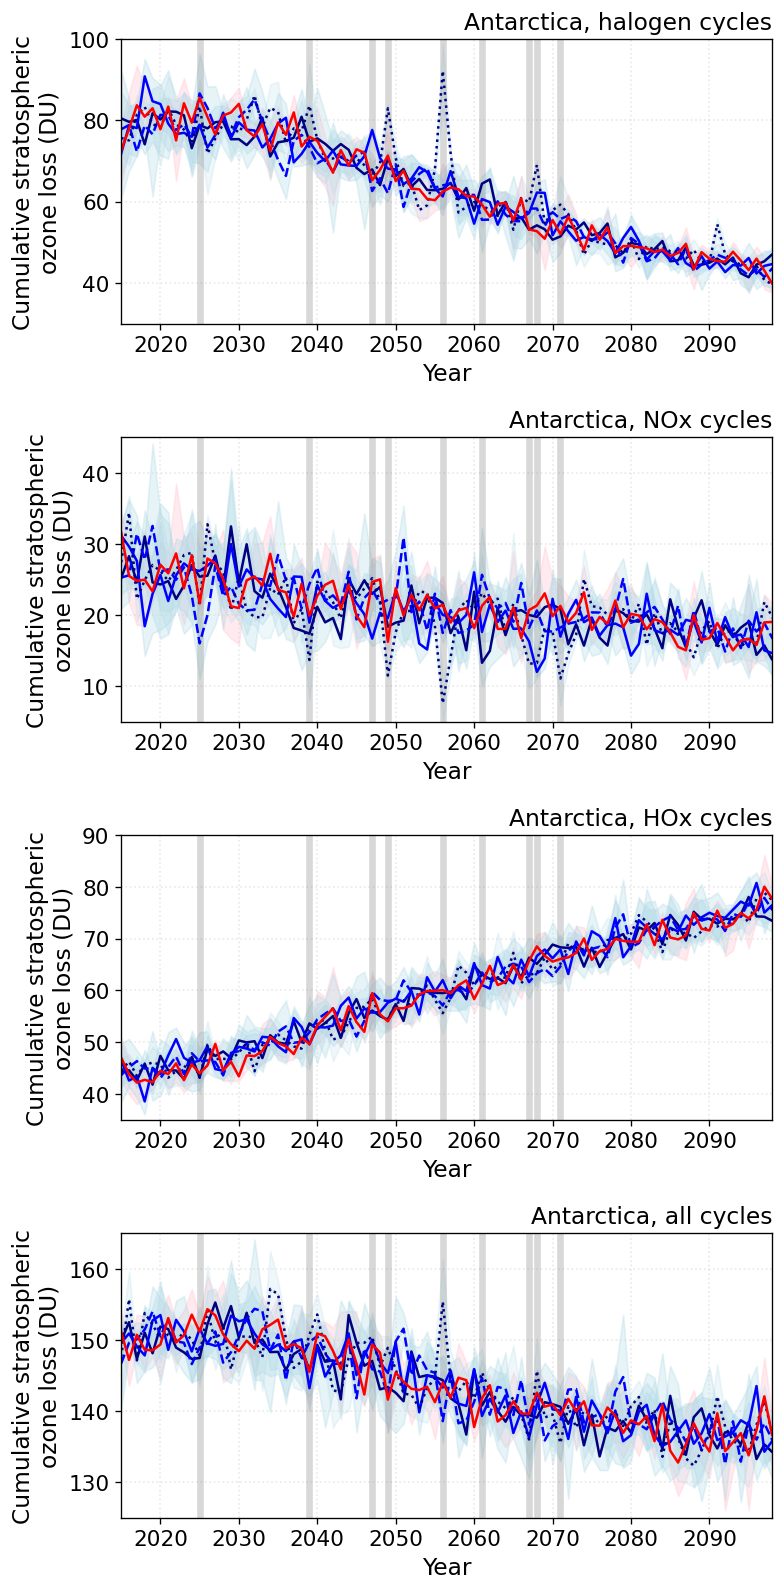

In [8]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(7, 16),dpi=120, gridspec_kw={'hspace': 0.4})

volc50_1_year = [2047,2068]
volc50_2_year = [2025]
volc25_year = [2061]
volc98_year = [2039,2049,2056,2067,2071]
erup_year = volc50_1_year+volc50_2_year+volc25_year+volc98_year

year_axis = np.arange(2015,2101,1)

cycles = ['halogen','NOx','HOx','all']
for i, ax in zip(range(4), (ax1,ax2,ax3,ax4)):
    plot_cumulative_time_series(erup_year, data_ens, data_allens, data_ens_novolc, data_allens_novolc, cycles[i], ax)
    ax.set_title('Antarctica, '+cycles[i]+ ' cycles', loc='right', fontsize = 14)
    ax.set_ylabel('Cumulative stratospheric\nozone loss (DU)', fontsize = 14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    ax.grid(ls='dotted',color='lightgrey',lw=1)

ax1.set_ylim(30,100)
ax2.set_ylim(5,45)
ax3.set_ylim(35,90)
ax4.set_ylim(125,165)


## Plot Figure S5

In [10]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list(calc_annual_SH, cycle_all, None)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list(calc_annual_SH, NOx_all, 'm01s50i117')
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list(calc_annual_SH, ClOx_all, '__xarray_dataarray_variable__')
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list(calc_annual_SH, HOx_all, '__xarray_dataarray_variable__')

data_allens = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
data_ens_novolc = {'all': novolc_list_all[1],'NOx': novolc_list_NOx[1],'halogen':novolc_list_halo[1],'HOx': novolc_list_HOx[1]}
data_allens_novolc = {'all': novolc_list_all[0],'NOx': novolc_list_NOx[0],'halogen':novolc_list_halo[0],'HOx': novolc_list_HOx[0]}

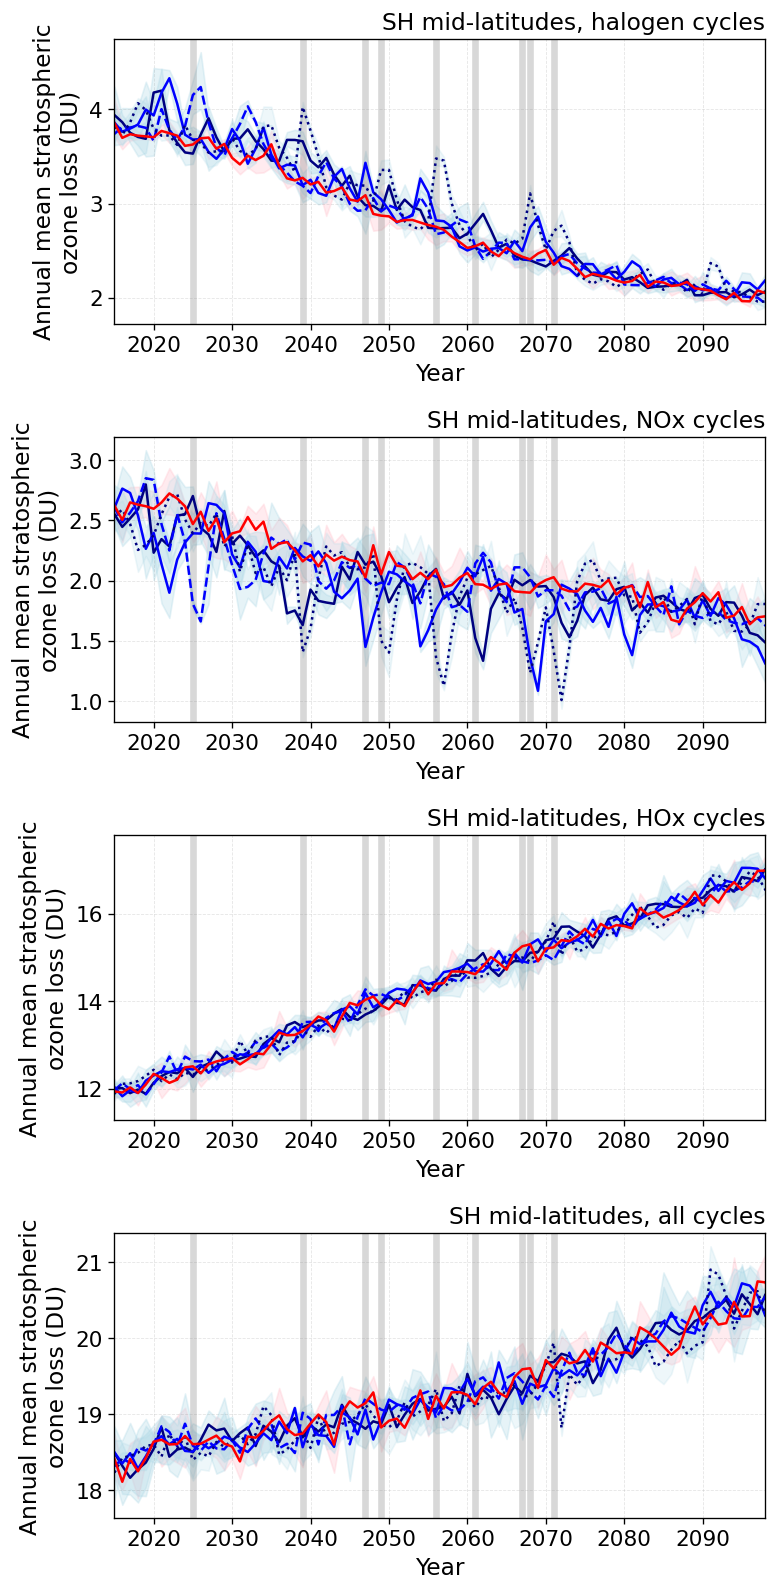

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(7, 16),dpi=120, gridspec_kw={'hspace': 0.4})

volc50_1_year = [2047,2068]
volc50_2_year = [2025]
volc25_year = [2061]
volc98_year = [2039,2049,2056,2067,2071]
erup_year = volc50_1_year+volc50_2_year+volc25_year+volc98_year

ax.grid(ls='dotted',color='lightgrey',lw=1)

year_axis = np.arange(2015,2101,1)
cycles = ['halogen','NOx','HOx','all']

for i, ax in zip(range(4), (ax1,ax2,ax3,ax4)):
    plot_cumulative_time_series(erup_year, data_ens, data_allens, data_ens_novolc, data_allens_novolc, cycles[i], ax)
    ax.set_title('SH mid-latitudes, '+cycles[i]+ ' cycles', loc='right', fontsize = 14)
    ax.set_ylabel('Annual mean stratospheric\nozone loss (DU)', fontsize = 14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
    

## Plot Figure S6

In [12]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list(calc_annual_NH, cycle_all, None)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list(calc_annual_NH, NOx_all, 'm01s50i117')
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list(calc_annual_NH, ClOx_all, '__xarray_dataarray_variable__')
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list(calc_annual_NH, HOx_all, '__xarray_dataarray_variable__')

data_allens = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
data_ens_novolc = {'all': novolc_list_all[1],'NOx': novolc_list_NOx[1],'halogen':novolc_list_halo[1],'HOx': novolc_list_HOx[1]}
data_allens_novolc = {'all': novolc_list_all[0],'NOx': novolc_list_NOx[0],'halogen':novolc_list_halo[0],'HOx': novolc_list_HOx[0]}

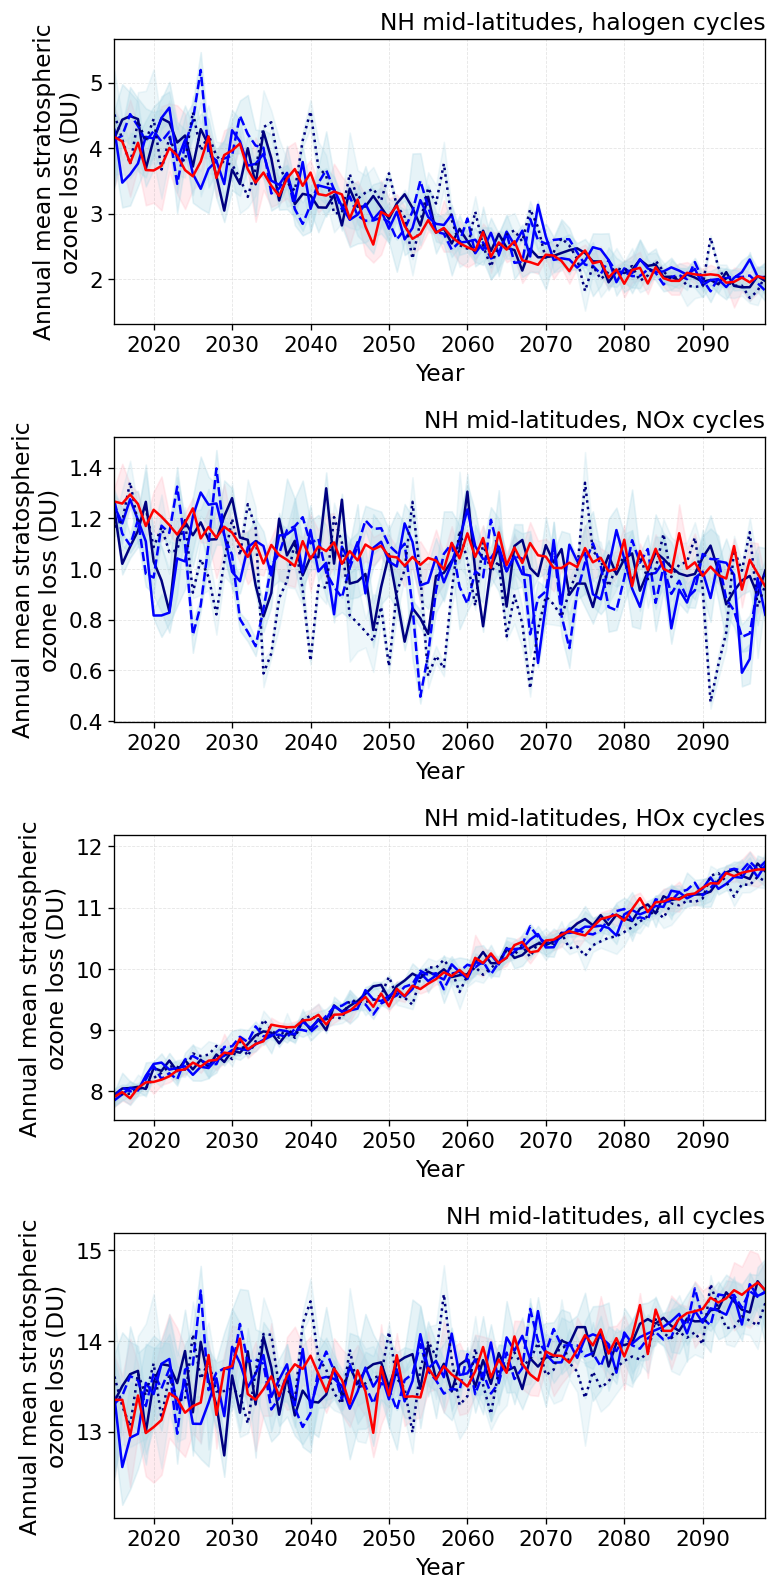

In [13]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(7, 16),dpi=120, gridspec_kw={'hspace': 0.4})

volc50_1_year = [2047,2068]
volc50_2_year = [2025]
volc25_year = [2061]
volc98_year = [2039,2049,2056,2067,2071]
erup_year = volc50_1_year+volc50_2_year+volc25_year+volc98_year

ax.grid(ls='dotted',color='lightgrey',lw=1)

year_axis = np.arange(2015,2101,1)
cycles = ['halogen','NOx','HOx','all']

for i, ax in zip(range(4), (ax1,ax2,ax3,ax4)):
    plot_cumulative_time_series([], data_ens, data_allens, data_ens_novolc, data_allens_novolc, cycles[i], ax)
    ax.set_title('NH mid-latitudes, '+cycles[i]+ ' cycles', loc='right', fontsize = 14)
    ax.set_ylabel('Annual mean stratospheric\nozone loss (DU)', fontsize = 14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
    

## Plot Figure S7

In [14]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list(calc_annual_Arctic, cycle_all, None)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list(calc_annual_Arctic, NOx_all, 'm01s50i117')
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list(calc_annual_Arctic, ClOx_all, '__xarray_dataarray_variable__')
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list(calc_annual_Arctic, HOx_all, '__xarray_dataarray_variable__')

data_allens = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
data_ens_novolc = {'all': novolc_list_all[1],'NOx': novolc_list_NOx[1],'halogen':novolc_list_halo[1],'HOx': novolc_list_HOx[1]}
data_allens_novolc = {'all': novolc_list_all[0],'NOx': novolc_list_NOx[0],'halogen':novolc_list_halo[0],'HOx': novolc_list_HOx[0]}

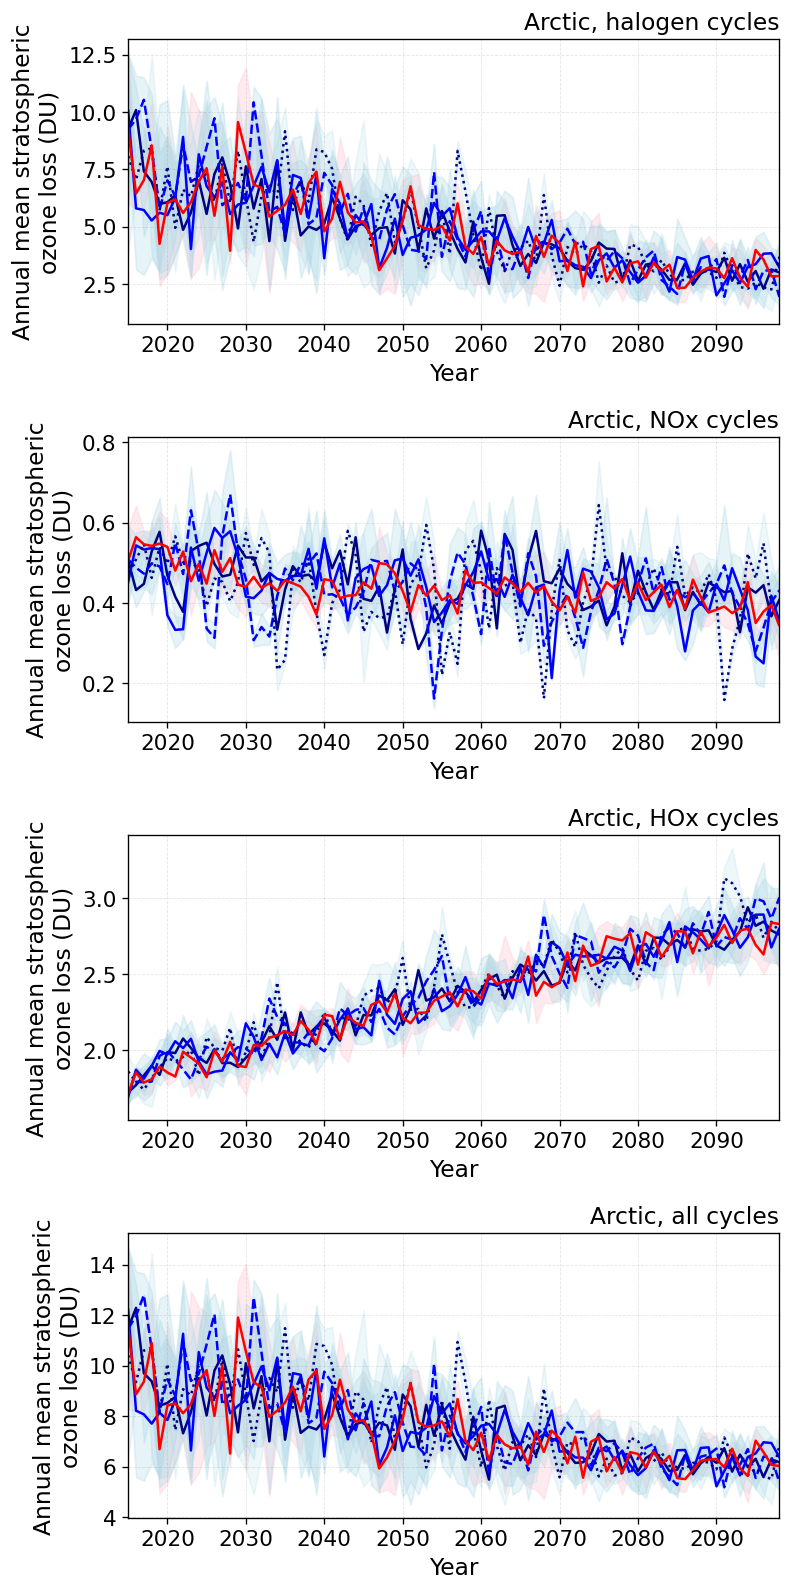

In [15]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(7, 16),dpi=120, gridspec_kw={'hspace': 0.4})

volc50_1_year = [2047,2068]
volc50_2_year = [2025]
volc25_year = [2061]
volc98_year = [2039,2049,2056,2067,2071]
erup_year = volc50_1_year+volc50_2_year+volc25_year+volc98_year

ax.grid(ls='dotted',color='lightgrey',lw=1)

year_axis = np.arange(2015,2101,1)
cycles = ['halogen','NOx','HOx','all']

for i, ax in zip(range(4), (ax1,ax2,ax3,ax4)):
    plot_cumulative_time_series([], data_ens, data_allens, data_ens_novolc, data_allens_novolc, cycles[i], ax)
    ax.set_title('Arctic, '+cycles[i]+ ' cycles', loc='right', fontsize = 14)
    ax.set_ylabel('Annual mean stratospheric\nozone loss (DU)', fontsize = 14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
    